In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 1


In [7]:
# %%
import os, json, re, math, gc
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt

# audio
import librosa, soundfile as sf

# vision
import cv2
import torch, open_clip
from PIL import Image

# NLP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler


# paths (edit if needed)
BASE = Path(".").resolve()
DATA = BASE / "data"
RAW  = DATA / "raw"
OUT  = BASE / "out"
OUT.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA / "videos.csv"
assert CSV_PATH.exists(), f"Missing {CSV_PATH}"


TRANS_DIR = OUT / "transcripts"
TRANS_DIR.mkdir(exist_ok=True, parents=True)

In [8]:
# %%
meta = pd.read_csv(CSV_PATH, dtype=str)
for c in ["duration_sec","viewCount","likeCount","commentCount"]:
    if c in meta.columns:
        meta[c] = pd.to_numeric(meta[c], errors="coerce")

meta["publishedAt"] = pd.to_datetime(meta["publishedAt"], errors="coerce", utc=True)

def has_files(vid: str) -> bool:
    d = RAW / vid
    return (d / f"{vid}.mp4").exists() and (d / f"{vid}.wav").exists()

meta["has_media"] = meta["video_id"].apply(has_files)
print("Rows:", len(meta), "with media:", meta["has_media"].sum())

meta = meta[meta["has_media"]].copy()
meta.head()


Rows: 1500 with media: 1165


,video_id,publishedAt,channelId,channelTitle,title,description,duration_sec,viewCount,likeCount,commentCount,tags,has_media
0,pzeGN3eEsMA,2023-10-06 23:24:21+00:00,UCc0vRNRARO5EQrHdB9zFYYw,Kerolos2007,٧ أكتوبر ٢٠٢٣,NaN,12,2504,68.0,0.0,NaN,True
1,7kbJ5uuig98,2023-10-07 00:41:19+00:00,UC4r6-Pgj7OHgW8nE1agtkXQ,Rare Error coins & LH,7 באוקטובר 2023,NaN,51,59,6.0,0.0,NaN,True
2,vd_0DqUfN9c,2023-10-07 02:39:00+00:00,UC5XxZlPp5vQTN9KakLAXOvA,Arye Avriel,7 באוקטובר 2023,NaN,61,3,0.0,0.0,NaN,True
3,PlM1a4UjVec,2023-10-07 05:13:53+00:00,UCuMjA1y83heM7kuyRprIC-Q,مقداد راشد,٧ أكتوبر ٢٠٢٣,NaN,18,720,34.0,0.0,NaN,True
4,yyG1KdO_hkk,2023-10-07 05:42:30+00:00,UCMmARi1wAhefLpT2mjZ_cdQ,بلقيس,٧ أكتوبر ٢٠٢٣,NaN,38,2605,48.0,3.0,NaN,True


In [10]:
# %%
rows = []
for vid in tqdm(meta["video_id"], desc="Load transcripts"):
    p = TRANS_DIR / f"{vid}.json"
    if not p.exists():
        rows.append({"video_id": vid, "language": None, "transcript": ""})
        continue
    js = json.loads(p.read_text(encoding="utf-8"))
    text = " ".join(s["text"] for s in js.get("segments", []))
    rows.append({"video_id": vid, "language": js.get("language"), "transcript": text})

tx = pd.DataFrame(rows)
meta_tx = meta.merge(tx, on="video_id", how="left")
meta_tx.to_csv(OUT / "meta_with_transcripts.csv", index=False)
meta_tx.sample(3)


Load transcripts: 100%|██████████| 1165/1165 [00:00<00:00, 1769.51it/s]


,video_id,publishedAt,channelId,channelTitle,title,description,duration_sec,viewCount,likeCount,commentCount,tags,has_media,language,transcript
794,qg8ALhV1pR4,2025-01-23 23:59:11+00:00,UCahpxixMCwoANAftn6IxkTg,AlArabiya العربية,ترمب: وقف إطلاق النار في غزة هو موضوع شائك,"الرئيس الأميركي دونالد #ترمب يؤكد لـ ""العربية""...",20,139051,1347.0,80.0,NaN,True,en,You showed great confidence in Steve Westcour...
538,h7yK5Uujv4I,2024-09-02 16:16:33+00:00,UCjkETDTi-OBxrN4z5lvaL5A,CHCH News,Israelis erupt in protest to demand a cease-fi...,Tens of thousands of grieving and angry Israel...,42,530,7.0,1.0,NaN,True,en,His grieving and angry Israelis took to the s...
898,o3PXWzd7kX0,2025-04-11 15:11:08+00:00,UCR0fZh5SBxxMNYdg0VzRFkg,Middle East Eye,Jordanians protest for Gaza in Amman,Jordanians demonstrated in solidarity with Pal...,39,202760,15753.0,674.0,middle east eye|mee|mee news|news|middle east ...,True,ar,مباشرة يرامي أدخل أدخل أدخل أدخل الله أ...


### 3) Preprocessing filter (keep relevant videos)

In [12]:
# %%
EN = [
    "october 7", "7 october", "7/10", "israel", "hamas", "gaza", "hostage", "war", "ceasefire",
    "protest", "rally", "military", "attack", "massacre"]
HE = [
    "7 באוקטובר", "חמאס", "גזה", "מלחמה", "חטופים", "מתווה", "שבויים", "טרור", "טבח",
    "ירי", "חדירה", "פיגוע", "הפגנה", "צבא", "מילואים"
]
AR = [
    "٧ أكتوبر", "7 اكتوبر", "غزة", "حماس", "اسرائيل", "حرب", "هدنة", "الأسرى",
    "مظاهرة", "قصف", "هجوم", "مسيرة", "جيش"
]

all_terms = [t.lower() for t in (EN + HE + AR)]
re_kw = re.compile("|".join([re.escape(t) for t in sorted(all_terms, key=len, reverse=True)]), flags=re.IGNORECASE)

def kw_score(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(re.findall(re_kw, text.lower()))

# semantic model
msbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

queries = [
    "Videos about the October 7 events and the war in Israel and Gaza",
    "Protests, rallies, hostages, ceasefire, military escalation",
]
Q = msbert.encode(queries, normalize_embeddings=True)

def semantic_score(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return 0.0
    v = msbert.encode([text], normalize_embeddings=True)[0]
    # max cosine vs queries
    return float(np.max(np.dot(Q, v)))

# Build text field (title + description + transcript)
meta_tx["text_all"] = (meta_tx["title"].fillna("") + " " +
                       meta_tx["description"].fillna("") + " " +
                       meta_tx["transcript"].fillna(""))

meta_tx["kw_score"] = meta_tx["text_all"].apply(kw_score)

# Quick semantic score (you can batch if the set is big)
scores = []
for t in tqdm(meta_tx["text_all"], desc="SemSim"):
    scores.append( semantic_score(t) )
meta_tx["sem_score"] = scores

# Keep if enough keywords OR decent semantic match
KEEP = (meta_tx["kw_score"] >= 2) | (meta_tx["sem_score"] >= 0.35)
filtered = meta_tx[KEEP].copy()

print("Kept:", len(filtered), "of", len(meta_tx))
filtered.to_csv(OUT / "filtered.parquet", index=False)
filtered[["video_id","kw_score","sem_score","title"]].head(10)


SemSim: 100%|██████████| 1165/1165 [00:07<00:00, 148.04it/s]


Kept: 1022 of 1165


,video_id,kw_score,sem_score,title
2,vd_0DqUfN9c,2,0.341983,7 באוקטובר 2023
3,PlM1a4UjVec,1,0.387277,٧ أكتوبر ٢٠٢٣
4,yyG1KdO_hkk,2,0.328006,٧ أكتوبر ٢٠٢٣
6,JBZHp5lfJ0o,5,0.708579,مشاهد لجنود إسرائيلين داخل قاعدة عسكرية قرب غ...
7,_2bnrLB0720,7,0.719921,"القسام تبث مشاهد حصرية لسرب ""صقر"" إحدى الوحدات..."
8,BHwIxpWpvls,1,0.507807,٧ أكتوبر ٢٠٢٣
11,RDq-z7vNYEU,7,0.662015,"Israel | Hamas Attack in Southern Israel, peop..."
14,tAPcTU5jPTw,1,0.376474,٧ أكتوبر ٢٠٢٣
17,_UPSU2dEJbM,11,0.607485,Israel: Hamas fighters appear to paraglide acr...
20,uR7cagO-XpQ,1,0.379336,٧ أكتوبر ٢٠٢٣


### 4) Audio: Hard-Hitting Music Index (HHI)


 Compute MIR features + HHI per video (energy/percussiveness proxy)

In [14]:
# %%
def audio_feats_for(wav_path: Path, target_sr=16000):
    y, sr = librosa.load(str(wav_path), sr=target_sr, mono=True)
    hop = 512
    # RMS / loudness proxy
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=hop)[0]
    rms_mean = float(np.mean(rms))
    # Onset strength ~ spectral flux
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    flux = float(np.mean(onset_env))
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    onset_rate = float(len(onsets) / (len(y)/sr + 1e-9))
    # Tempo
    tempo = float(librosa.feature.tempo(onset_envelope=onset_env, sr=sr)[0])
    # Dynamic range (95th - 5th percentile of RMS dB)
    rms_db = 20*np.log10(np.maximum(rms, 1e-9))
    dr = float(np.percentile(rms_db, 95) - np.percentile(rms_db, 5))
    return dict(rms=rms_mean, flux=flux, onset_rate=onset_rate, tempo=tempo, dyn_range_db=dr)

afeats = []
for vid in tqdm(filtered["video_id"], desc="Audio feats"):
    wav = RAW / vid / f"{vid}.wav"
    if not wav.exists(): 
        continue
    try:
        f = audio_feats_for(wav)
        f["video_id"] = vid
        afeats.append(f)
    except Exception as e:
        print("Audio error", vid, e)

afeats = pd.DataFrame(afeats).set_index("video_id")

# z-score + weighted sum
Z = (afeats - afeats.mean())/(afeats.std(ddof=0)+1e-9)
HHI = ( Z["rms"] + Z["flux"] + Z["onset_rate"] + (Z["tempo"]/1.0) - Z["dyn_range_db"] )
afeats = afeats.join(HHI.rename("HHI"))
afeats.reset_index().to_csv(OUT / "audio_features.csv", index=False)
afeats.head()


Audio feats: 100%|██████████| 1022/1022 [01:20<00:00, 12.74it/s]


,rms,flux,onset_rate,tempo,dyn_range_db,HHI
video_id,,,,,,
vd_0DqUfN9c,0.045917,2.136659,7.531639,125.000000,23.438751,1.784385
PlM1a4UjVec,0.073083,1.168105,2.286921,170.454545,166.038589,-2.162376
yyG1KdO_hkk,0.202606,1.530010,0.634023,104.166667,6.398698,-1.164329
JBZHp5lfJ0o,0.067972,1.623863,6.316739,125.000000,21.345829,0.627882
_2bnrLB0720,0.131073,1.206436,3.388851,125.000000,29.518114,-0.698889


In [24]:
import imageio, imageio_ffmpeg as iio_ffmpeg
from PIL import Image
import numpy as np
import cv2
from pathlib import Path

import tempfile, shutil, subprocess, uuid
labels = ["protest","flag","explosion","military","rally","fire","police","crowd","violence","smoke","war"]
device = "cuda" if torch.cuda.is_available() else "cpu" 
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k", device=device) 
tok = open_clip.get_tokenizer("ViT-B-32") 

text = tok([f"a photo of {l}" for l in labels]).to(device) 

with torch.no_grad(): 
    tfeat = model.encode_text(text) 
    tfeat /= tfeat.norm(dim=-1, keepdim=True)
    
def frame_iter(mp4_path: Path, fps=1.0):
    """Yield PIL RGB frames sampled at ~fps. Try OpenCV first, then imageio-ffmpeg, 
    finally extract JPEGs via ffmpeg as a last resort."""
    # 1) Try OpenCV (fast if codec supported)
    try:
        cap = cv2.VideoCapture(str(mp4_path))
        if cap.isOpened():
            native = cap.get(cv2.CAP_PROP_FPS) or 30.0
            step = max(int(round(native / max(fps, 1e-6))), 1)
            idx, any_frame = 0, False
            while True:
                ok, frame = cap.read()
                if not ok:
                    break
                any_frame = True
                if idx % step == 0:
                    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    yield Image.fromarray(rgb)
                idx += 1
            cap.release()
            if any_frame:
                return
    except Exception:
        pass

    # 2) Fallback: imageio-ffmpeg (software AV1 decode)
    try:
        reader = imageio.get_reader(
            str(mp4_path),
            format="ffmpeg",
            mode="I",
            # IMPORTANT: put filter on OUTPUT, not input
            output_params=["-vf", f"fps={fps}", "-fps_mode", "vfr"],
            # imageio sets -nostdin itself; no need to add it
        )
        for frame in reader:
            yield Image.fromarray(frame)  # already RGB
        reader.close()
        return
    except Exception:
        pass

    # 3) Last resort: extract frames to temp dir via ffmpeg CLI, then read
    tmpdir = Path(tempfile.gettempdir()) / f"frames_{uuid.uuid4().hex}"
    tmpdir.mkdir(parents=True, exist_ok=True)
    outpat = str(tmpdir / "%06d.jpg")
    ffmpeg_bin = iio_ffmpeg.get_ffmpeg_exe()
    cmd = [
        ffmpeg_bin, "-hide_banner", "-loglevel", "error",
        "-i", str(mp4_path),
        "-vf", f"fps={fps},scale=trunc(iw/2)*2:trunc(ih/2)*2",  # ensure even dims for some codecs
        "-qscale:v", "2", outpat
    ]
    try:
        subprocess.run(cmd, check=True)
        for jpg in sorted(tmpdir.glob("*.jpg")):
            yield Image.open(jpg).convert("RGB")
    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

vrows = []
for vid in tqdm(filtered["video_id"], desc="OpenCLIP"):  # or meta["video_id"]
    mp4 = RAW / vid / f"{vid}.mp4"
    if not mp4.exists():
        continue
    sims = []
    for img in frame_iter(mp4, fps=1.0):
        imt = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            imf = model.encode_image(imt)
            imf /= imf.norm(dim=-1, keepdim=True)
            logits = (imf @ tfeat.T).softmax(dim=-1).squeeze(0).detach().cpu().numpy()
            sims.append(logits)
    if not sims:
        continue
    arr = np.vstack(sims)
    mean_scores = arr.mean(axis=0)
    d = {f"p_{lab}": float(mean_scores[i]) for i, lab in enumerate(labels)}
    d["video_id"] = vid
    d["VII"] = float(mean_scores.max())
    vrows.append(d)

vfeats = pd.DataFrame(vrows)
(vfeats
 .sort_values("VII", ascending=False)
 .reset_index(drop=True))
# write as Parquet (fast, typed) OR CSV with matching extension
vfeats.to_csv(OUT / "vision_features.csv", index=False)
# vfeats.to_csv(OUT / "vision_features.csv", index=False)


OpenCLIP:   0%|          | 3/1022 [00:03<18:38,  1.10s/it][av1 @ 0xde9c640] Your platform doesn't suppport hardware accelerated AV1 decoding.
[av1 @ 0xde9c640] Failed to get pixel format.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Header.
[av1 @ 0xde9c640] Missing Sequence Hea

In [28]:
# %%
tbl = (filtered
       .merge(afeats.reset_index(), on="video_id", how="left")
       .merge(vfeats, on="video_id", how="left"))

tbl.to_csv(OUT / "features.csv", index=False)
tbl[["video_id","publishedAt","HHI","VII","kw_score","sem_score","channelId"]].head()


,video_id,publishedAt,HHI,VII,kw_score,sem_score,channelId
0,vd_0DqUfN9c,2023-10-07 02:39:00+00:00,1.784385,0.101621,2,0.341983,UC5XxZlPp5vQTN9KakLAXOvA
1,PlM1a4UjVec,2023-10-07 05:13:53+00:00,-2.162376,0.102572,1,0.387277,UCuMjA1y83heM7kuyRprIC-Q
2,yyG1KdO_hkk,2023-10-07 05:42:30+00:00,-1.164329,0.102103,2,0.328006,UCMmARi1wAhefLpT2mjZ_cdQ
3,JBZHp5lfJ0o,2023-10-07 07:45:08+00:00,0.627882,0.106752,5,0.708579,UCahpxixMCwoANAftn6IxkTg
4,_2bnrLB0720,2023-10-07 08:45:01+00:00,-0.698889,0.103414,7,0.719921,UCfiwzLy-8yKzIbsmZTzxDgw


### 7) First Model (NLP): Topic/stance shift over time

NLP: mSBERT embeddings + KMeans topics, then time distribution

In [29]:
# %%
nlp_df = tbl.dropna(subset=["transcript"]).copy()
nlp_df["month"] = nlp_df["publishedAt"].dt.to_period("M").dt.to_timestamp()

# embeddings
model_sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
E = model_sbert.encode(nlp_df["transcript"].tolist(), normalize_embeddings=True, show_progress_bar=True)

# KMeans topics
K = 8
km = KMeans(n_clusters=K, n_init=10, random_state=42)
nlp_df["topic"] = km.fit_predict(E)

# quick topic labels via TF-IDF top terms
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(nlp_df["transcript"])
terms = np.array(tfidf.get_feature_names_out())

def top_terms_for_topic(topic_id, n=8):
    idx = np.where(nlp_df["topic"].values == topic_id)[0]
    if len(idx)==0: return []
    mean_vec = X_tfidf[idx].mean(axis=0).A1
    top = terms[np.argsort(mean_vec)[-n:]][::-1]
    return top.tolist()

topic_labels = {k: ", ".join(top_terms_for_topic(k)) for k in range(K)}
topic_labels


/tmp/ipykernel_2164490/2734635341.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  nlp_df["month"] = nlp_df["publishedAt"].dt.to_period("M").dt.to_timestamp()
Batches: 100%|██████████| 32/32 [00:00<00:00, 63.60it/s]


{0: 'the, of, to, and, in, that, for, hamas',
 1: 'אני, you, את, לא, for watching, watching, thank you, thank',
 2: 'you, you you, says, school, se, sea, sebagai, second',
 3: 'לא, את, זה, the, אני, של, על, to',
 4: 'في, من, على, غزة, النار, أن, وقف, حماس',
 5: 'music, music music, music you, you, 韻譜, 韻譜 韻譜, thank you, thank',
 6: 'את, the, ישראל, לא, של, and, זה, to',
 7: 'من, في, الله, يا, على, ما, لا, كل'}


#### Plot topic prevalence over months (stacked area)


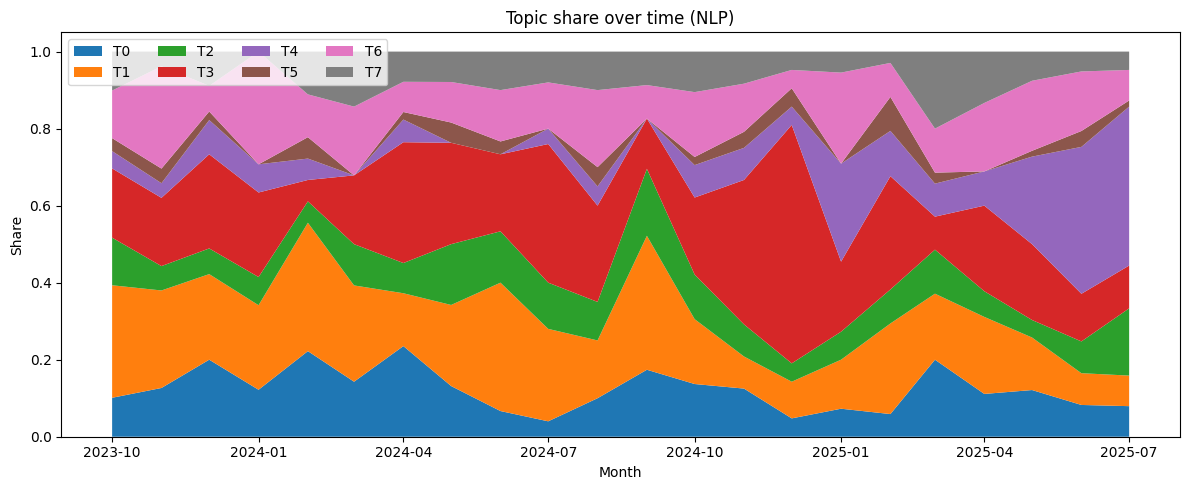

In [30]:
# %%
topic_counts = (nlp_df
                .groupby(["month","topic"])
                .size()
                .reset_index(name="count"))
topic_pivot = topic_counts.pivot(index="month", columns="topic", values="count").fillna(0)
topic_pivot = topic_pivot.div(topic_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(12,5))
plt.stackplot(topic_pivot.index, topic_pivot.values.T, labels=[f"T{k}" for k in topic_pivot.columns])
plt.legend(loc="upper left", ncols=4)
plt.title("Topic share over time (NLP)")
plt.xlabel("Month"); plt.ylabel("Share")
plt.tight_layout(); plt.show()



#### Simple Early vs Late classifier (which words/embeddings distinguish them?)


In [31]:
# %%
cut = pd.Timestamp("2024-01-31", tz="UTC")  # adjust as you like
nlp_df["era"] = np.where(nlp_df["publishedAt"] <= cut, "early", "late")

# TF-IDF baseline
X = X_tfidf
y = nlp_df["era"].values

# time-aware split by channel (avoid leakage)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=nlp_df["channelId"]))

clf = LogisticRegression(max_iter=2000)
clf.fit(X[train_idx], y[train_idx])

pred = clf.predict(X[test_idx])
print(classification_report(y[test_idx], pred))
# Top features toward "early"
coefs = clf.coef_[0]
top_early = terms[np.argsort(coefs)[:20]]
top_late  = terms[np.argsort(coefs)[-20:]][::-1]
print("Top EARLY indicators:", ", ".join(top_early))
print("Top LATE indicators:", ", ".join(top_late))


              precision    recall  f1-score   support

       early       0.00      0.00      0.00        53
        late       0.77      1.00      0.87       173

    accuracy                           0.77       226
   macro avg       0.38      0.50      0.43       226
weighted avg       0.59      0.77      0.66       226

Top EARLY indicators: תודה, ישראל, we, המדינה, בישראל, يا, אותה, you in, in, אחרי, ve, now, see you, اليهود, המלחמה, free, will, to, כל, وإسرائيل
Top LATE indicators: זה, לא, النار, إلى, october, 7th, it, hostages, أن, وقف, day, למה, حماس, على, إن, عن, الله, الحرب, من, de


/home/yuvalhai/.conda/envs/miki_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yuvalhai/.conda/envs/miki_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/yuvalhai/.conda/envs/miki_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

### 8) Second Model (Vision): Visual-intensity shift classifier

In [32]:
# %%
vis_cols = [c for c in tbl.columns if c.startswith("p_")] + ["VII"]
vis_df = tbl.dropna(subset=vis_cols).copy()
vis_df["era"] = np.where(vis_df["publishedAt"] <= cut, "early", "late")

X = vis_df[vis_cols].values
y = vis_df["era"].values

# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=vis_df["channelId"]))

clf = LogisticRegression(max_iter=1000)
clf.fit(X[train_idx], y[train_idx])
pred = clf.predict(X[test_idx])
print(classification_report(y[test_idx], pred))

coef = pd.Series(clf.coef_[0], index=vis_cols).sort_values()
print("↓ Early era visuals:\n", coef.head(10))
print("\n↑ Late era visuals:\n", coef.tail(10))


              precision    recall  f1-score   support

       early       0.33      0.04      0.07        53
        late       0.77      0.98      0.86       173

    accuracy                           0.76       226
   macro avg       0.55      0.51      0.46       226
weighted avg       0.67      0.76      0.67       226

↓ Early era visuals:
 VII           -0.470411
p_smoke       -0.232326
p_crowd       -0.148536
p_explosion   -0.096691
p_fire        -0.059089
p_police      -0.048664
p_protest      0.008802
p_flag         0.033731
p_military     0.067734
p_rally        0.178759
dtype: float64

↑ Late era visuals:
 p_smoke       -0.232326
p_crowd       -0.148536
p_explosion   -0.096691
p_fire        -0.059089
p_police      -0.048664
p_protest      0.008802
p_flag         0.033731
p_military     0.067734
p_rally        0.178759
p_violence     0.360445
dtype: float64


### 9) Third Model - Music over time: trend + change-points

/tmp/ipykernel_2164490/922418944.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aud_df["week"] = aud_df["publishedAt"].dt.to_period("W-MON").dt.start_time
/tmp/ipykernel_2164490/922418944.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aud_df["month"] = aud_df["publishedAt"].dt.to_period("M").dt.start_time
/tmp/ipykernel_2164490/922418944.py:72: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aud_df["week"] = aud_df["publishedAt"].dt.to_period("W-MON").dt.start_time
/tmp/ipykernel_2164490/922418944.py:73: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  aud_df["month"] = aud_df["publishedAt"].dt.to_period("M").dt.start_time


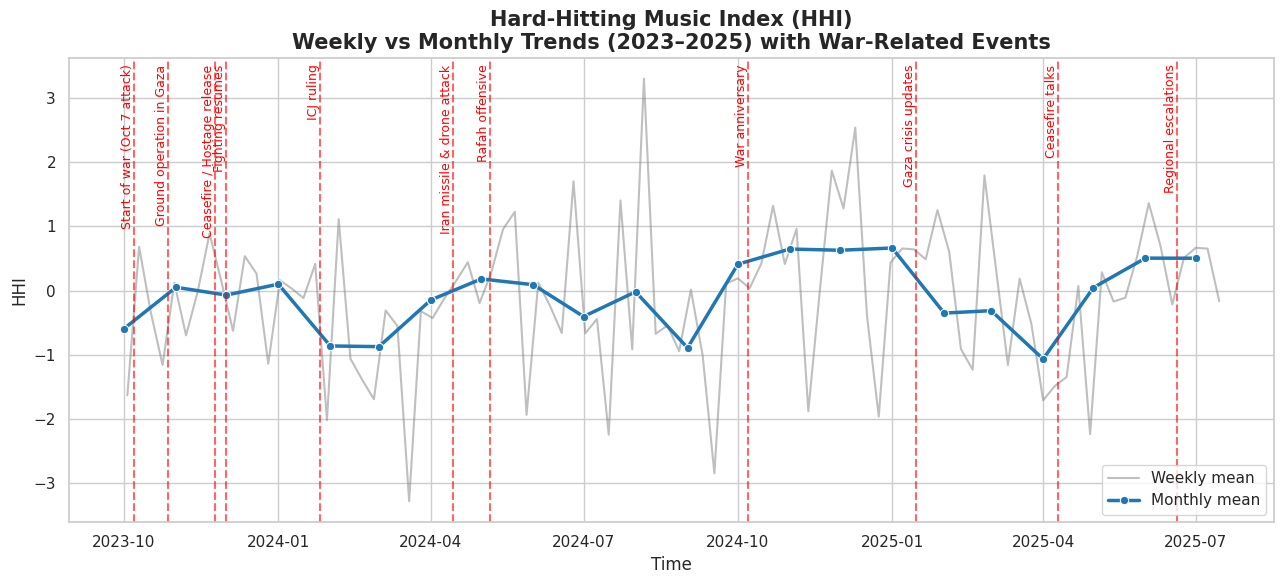

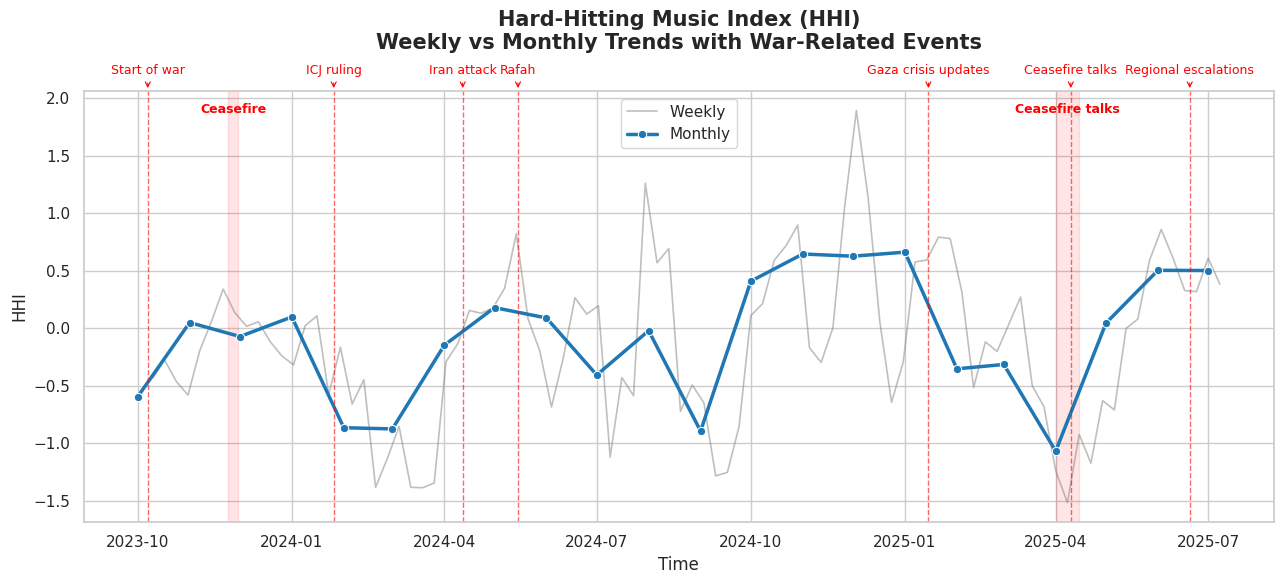

In [50]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Clean dataset
aud_df = tbl.dropna(subset=["HHI"]).copy()

# Aggregations
aud_df["week"] = aud_df["publishedAt"].dt.to_period("W-MON").dt.start_time
aud_df["month"] = aud_df["publishedAt"].dt.to_period("M").dt.start_time

weekly = aud_df.groupby("week")["HHI"].mean().reset_index()
monthly = aud_df.groupby("month")["HHI"].mean().reset_index()

# Events (2023–2025)
events = {
    # 2023
    "2023-10-07": "Start of war (Oct 7 attack)",
    "2023-10-27": "Ground operation in Gaza",
    "2023-11-24": "Ceasefire / Hostage release",
    "2023-12-01": "Fighting resumes",

    # 2024
    "2024-01-26": "ICJ ruling",
    "2024-04-14": "Iran missile & drone attack",
    "2024-05-06": "Rafah offensive",
    "2024-10-07": "War anniversary",

    # 2025
    "2025-01-15": "Gaza crisis updates",
    "2025-04-10": "Ceasefire talks",
    "2025-06-20": "Regional escalations"
}
events = {pd.to_datetime(k): v for k, v in events.items()}

# Seaborn styling
sns.set_theme(style="whitegrid")
plt.figure(figsize=(13,6))

# Weekly trend
sns.lineplot(data=weekly, x="week", y="HHI",
             color="gray", alpha=0.5, label="Weekly mean")

# Monthly trend
sns.lineplot(data=monthly, x="month", y="HHI",
             color="tab:blue", marker="o", linewidth=2.5,
             label="Monthly mean")

# Events overlay
ymax = plt.ylim()[1]
for date, label in events.items():
    plt.axvline(date, color="red", linestyle="--", alpha=0.6)
    plt.text(date, ymax*0.97, label, rotation=90,
             color="red", fontsize=9, ha="right", va="top")

# Titles & labels
plt.title("Hard-Hitting Music Index (HHI)\nWeekly vs Monthly Trends (2023–2025) with War-Related Events",
          fontsize=15, weight="bold")
plt.xlabel("Time")
plt.ylabel("HHI")
plt.legend()
plt.tight_layout()# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Clean dataset
aud_df = tbl.dropna(subset=["HHI"]).copy()

# Aggregations
aud_df["week"] = aud_df["publishedAt"].dt.to_period("W-MON").dt.start_time
aud_df["month"] = aud_df["publishedAt"].dt.to_period("M").dt.start_time

weekly = aud_df.groupby("week")["HHI"].mean().reset_index()
monthly = aud_df.groupby("month")["HHI"].mean().reset_index()

# Smooth weekly to reduce noise (3-week rolling mean)
weekly["HHI_smooth"] = weekly["HHI"].rolling(window=3, center=True).mean()

# Define events (key milestones only)
milestone_events = {
    "2023-10-07": "Start of war",
    "2024-01-26": "ICJ ruling",
    "2024-04-12": "Iran attack",
    "2024-05-15": "Rafah",
    "2025-01-15": "Gaza crisis updates",
    "2025-04-10": "Ceasefire talks",
    "2025-06-20": "Regional escalations"
}

# Define shaded event periods
event_periods = [
    ("2023-11-24", "2023-11-30", "Ceasefire"),
    ("2025-04-01", "2025-04-15", "Ceasefire talks")
]

# Convert dates
milestone_events = {pd.to_datetime(k): v for k, v in milestone_events.items()}
event_periods = [(pd.to_datetime(s), pd.to_datetime(e), lbl) for s, e, lbl in event_periods]

# ---- Plotting ----
sns.set_theme(style="whitegrid")
plt.figure(figsize=(13,6))

# Plot weekly (smoothed) in gray
sns.lineplot(data=weekly, x="week", y="HHI_smooth",
             color="gray", alpha=0.5, linewidth=1.2,
             label="Weekly ")

# Plot monthly in bold blue
sns.lineplot(data=monthly, x="month", y="HHI",
             color="tab:blue", marker="o", linewidth=2.5,
             label="Monthly")

# Add shaded spans for event periods
for start, end, label in event_periods:
    plt.axvspan(start, end, color="red", alpha=0.1)
    plt.text((start+ (end-start)/2), plt.ylim()[1]*0.95, label,
             ha="center", va="top", fontsize=9, color="red", weight="bold")

# Add vertical milestone lines + annotations
ymax = plt.ylim()[1]
for date, label in milestone_events.items():
    plt.axvline(date, color="red", linestyle="--", alpha=0.6, lw=1)
    plt.annotate(label,
                 xy=(date, ymax),
                 xytext=(0,10),
                 textcoords="offset points",
                 ha="center", va="bottom",
                 fontsize=9, color="red",
                 arrowprops=dict(arrowstyle="->", color="red", lw=0.8))

# Titles & labels
plt.title(
    "Hard-Hitting Music Index (HHI)\nWeekly vs Monthly Trends with War-Related Events",
    fontsize=15, weight="bold", pad=30   # 🔹 add padding
)

plt.xlabel("Time")
plt.ylabel("HHI")
plt.legend()
plt.tight_layout()
plt.show()

plt.show()
